# **311 NYC Service Requests - Data Cleaning**

In [32]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **311 Service Level Agreements - Data prep**

In [33]:
# Load 'Service Level Agreement' data for 311
sla = pd.read_csv('311_Service_Level_Agreements.csv')
sla = sla[['Problem', 'Problem_Details', 'SLA Hours']]
sla = sla.dropna(subset=["SLA Hours"])
sla.head()

,Problem,Problem_Details,SLA Hours
0,ACS Literature Request,NaN,168.0
1,Case Management Agency Complaint,NaN,336.0
2,Snow or Ice,Roadway,24.0
3,Home Delivered Meal - Missed Delivery,NaN,72.0
4,Legal Services Provider Complaint,NaN,336.0


In [34]:
# Group by and count unique SLA values
sla_check = (
    sla.groupby(["Problem", "Problem_Details"])["SLA Hours"]
    .nunique()
    .reset_index(name="unique_sla_count")
)

# 1. Total unique problem+problem_details
total_unique_pairs = sla_check.shape[0]

# 2. Count of pairs with more than 1 SLA value
pairs_with_multiple_sla = (sla_check["unique_sla_count"] > 1).sum()

print("Count of unique 'Problem' + 'Problem_Details' pairs:", total_unique_pairs)
print("Count of unique pairs with multiple SLA values:", pairs_with_multiple_sla)

Count of unique 'Problem' + 'Problem_Details' pairs: 1121
Count of unique pairs with multiple SLA values: 47


In [35]:
# Resolve multiple SLA values per Problem, Problem_Details
# Returns majority SLA. If tied, returns minimum for strict SLA breach detection.

def resolve_sla(group):
    counts = group.value_counts()
    max_count = counts.max()
    # Find SLA with max count
    candidates = counts[counts == max_count].index.tolist()
    if len(candidates) == 1:
        return candidates[0]
    else:
        return min(candidates)

sla = (
    sla.groupby(["Problem", "Problem_Details"])["SLA Hours"]
    .agg(resolve_sla)
    .reset_index()
)

## **311 NYC Service Requests Data**

In [36]:
# Load service requests data
df = pd.read_csv('311_Service_Requests.csv', low_memory = False)
pd.set_option('display.max_columns', None)
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,65702631,07/30/2025 02:29:58 AM,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11373,BRITTON AVENUE,BRITTON AVENUE,FORLEY STREET,GLEANE STREET,NaN,NaN,BLOCKFACE,QUEENS,NaN,NaN,Open,NaN,The Department of Transportation referred this...,07/30/2025 02:29:58 AM,04 QUEENS,NaN,QUEENS,NaN,NaN,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65697549,07/30/2025 02:26:34 AM,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11373,NaN,NaN,NaN,NaN,FORLEY STREET,WHITNEY AVENUE,INTERSECTION,QUEENS,NaN,NaN,Open,NaN,The Department of Transportation referred this...,07/30/2025 02:26:34 AM,04 QUEENS,NaN,QUEENS,1018657.0,210893.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.745462,-73.875828,"(40.74546222042261, -73.87582808820335)"
2,65702243,07/30/2025 02:13:56 AM,NaN,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,11215,325 5 AVENUE,5 AVENUE,NaN,NaN,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Open,NaN,The graffiti has been reported. The property o...,07/30/2025 02:13:56 AM,06 BROOKLYN,3.009820e+09,BROOKLYN,988836.0,184309.0,UNKNOWN,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.672561,-73.983468,"(40.67256118990717, -73.9834676152927)"
3,65701364,07/30/2025 01:10:27 AM,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11372,BROADWAY,BROADWAY,37 ROAD,72 STREET,NaN,NaN,BLOCKFACE,QUEENS,NaN,NaN,Open,NaN,The Department of Transportation referred this...,07/30/2025 01:10:27 AM,03 QUEENS,NaN,QUEENS,NaN,NaN,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,65704221,07/30/2025 12:49:53 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11413,134-29 218 STREET,218 STREET,MERRICK BOULEVARD,134 ROAD,MERRICK BOULEVARD,134 ROAD,ADDRESS,SPRINGFIELD GARDENS,218 STREET,NaN,In Progress,NaN,NaN,07/30/2025 01:16:46 AM,13 QUEENS,4.130120e+09,QUEENS,1053129.0,186891.0,PHONE,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.679381,-73.751668,"(40.679381402953126, -73.7516676618203)"


In [37]:
# Service Requests data
print(df.shape)

(3495773, 41)


### **Handling missing values**

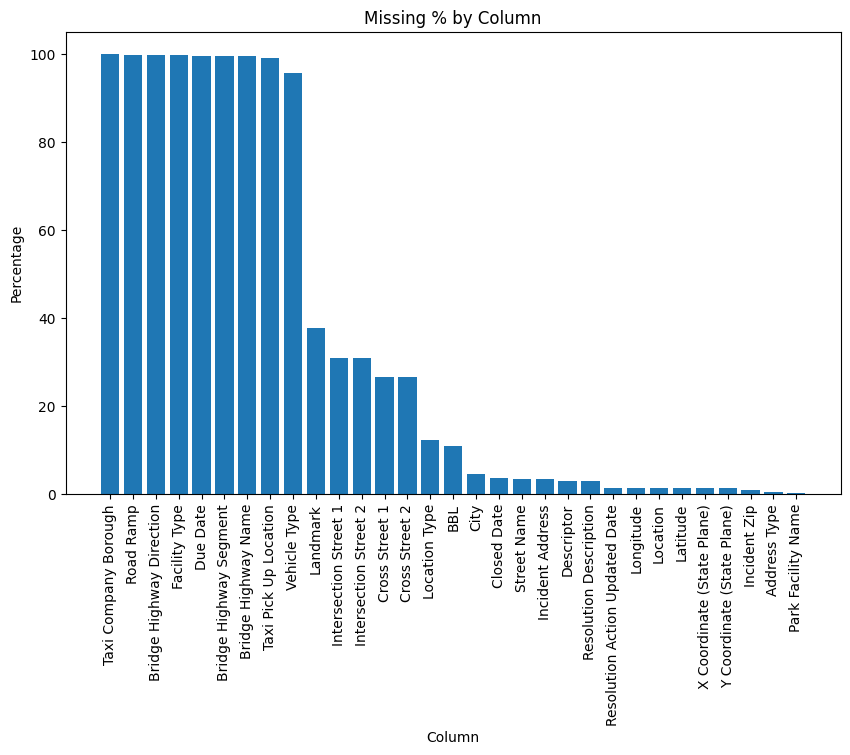

In [38]:
# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing_percent = (missing / len(df)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_percent.round(2)
})

plt.figure(figsize=(10, 6))
plt.bar(missing_table.index, missing_table['Missing %'])
plt.title('Missing % by Column')
plt.xlabel('Column')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()

In [39]:
# Remove columns with more than 80% missing values
missing_percentage = df.isna().mean()
columns_delete = missing_percentage[missing_percentage >= 0.8].index.tolist()
df = df.drop(columns = columns_delete)

In [40]:
# Explore data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3495773 entries, 0 to 3495772
Data columns (total 32 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unique Key                      int64  
 1   Created Date                    object 
 2   Closed Date                     object 
 3   Agency                          object 
 4   Agency Name                     object 
 5   Complaint Type                  object 
 6   Descriptor                      object 
 7   Location Type                   object 
 8   Incident Zip                    object 
 9   Incident Address                object 
 10  Street Name                     object 
 11  Cross Street 1                  object 
 12  Cross Street 2                  object 
 13  Intersection Street 1           object 
 14  Intersection Street 2           object 
 15  Address Type                    object 
 16  City                            object 
 17  Landmark                   

In [41]:
# Remove irrelevant columns
columns_drop = ['X Coordinate (State Plane)', 'Y Coordinate (State Plane)',
                'Park Facility Name', 'Park Borough', 'Incident Address',
                'Street Name', 'Cross Street 1', 'Cross Street 2',
                'Agency Name', 'Landmark', 'Intersection Street 1',
                'Intersection Street 2', 'City','BBL', 'Community Board',
                'Location', 'Resolution Action Updated Date',
                'Resolution Description']

df = df.drop(columns = columns_drop)

In [42]:
df.isna().sum()

,0
Unique Key,0
Created Date,0
Closed Date,128759
Agency,0
Complaint Type,0
Descriptor,101965
Location Type,428633
Incident Zip,31684
Address Type,14183
Status,0


### **Grouping categories & standardizing variables**

In [43]:
# Number of unique values in a column
print("Number of unique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

Number of unique values per column:
Unique Key: 3495773
Created Date: 2905616
Closed Date: 2352544
Agency: 14
Complaint Type: 194
Descriptor: 959
Location Type: 147
Incident Zip: 358
Address Type: 6
Status: 7
Borough: 6
Open Data Channel Type: 5
Latitude: 572160
Longitude: 572163


In [44]:
# Unique values of 'Location Type'
unique_locations = df['Location Type'].unique().astype(str)
sorted_locations = sorted(unique_locations)

for loc in sorted_locations:
    print(f"- {loc}")

- 1-2 Family Dwelling
- 1-2 Family Mixed Use Building
- 1-3 Family Dwelling
- 1-3 Family Mixed Use Building
- 3+ Family Apartment Building
- 3+ Family Apt. Building
- 3+ Family Mixed Use Building
- Abandoned Building
- Above Address
- Airport or Train/Bus Station
- Alley
- Apartment
- Beach
- Bike Lane
- Bridge
- Building
- Building (Non-Residential)
- Building Condition
- Building Entrance
- Bus Stop Shelter
- Business
- Cafeteria - College/University
- Cafeteria - Private
- Cafeteria - Private School
- Cafeteria - Public School
- Catch Basin/Sewer
- Catering Hall
- Catering Service
- Club/Bar/Restaurant
- Comercial
- Commercial
- Commercial Building
- Commercial Property
- Common Area
- Construction Site
- Correctional Facility - City
- Correctional Facility - State
- Crosswalk
- Curb
- Day Care/Nursery
- Ferry
- Food Cart Vendor
- Food Establishment or Vendor
- Garage
- Government Building
- Government Building - Foreign
- Green Cart Vendor
- Groomer
- Ground
- Gutter
- Hallway
- Hi

In [45]:
# Group categories to reduce sparsity
# Location Group
def map_location_type(val):
    residential = [
        'RESIDENTIAL BUILDING', 'Residential Building/House', '3+ Family Apt. Building',
        '1-2 Family Dwelling', '3+ Family Apartment Building', 'Residential Building',
        'Residential', '3+ Family Mixed Use Building', '1-2 Family Mixed Use Building',
        'Residence', 'Private House', 'Residential Property', 'House and Store',
        'Apartment', '1-3 Family Dwelling', 'Private Residence', '1-3 Family Mixed Use Building',
        'Loft Residence', 'Single Room Occupancy (SRO)', 'Mixed Use', 'Common Area',
        'Loft Building - Common Areas', 'Mixed Use Building'
    ]

    commercial = [
        'Store/Commercial', 'Club/Bar/Restaurant', 'Business',
        'Restaurant/Bar/Deli/Bakery', 'Comercial', 'Commercial Building',
        'Building (Non-Residential)', 'Tattoo Parlor', 'Retail Store',
        'Catering Service', 'Restaurant', 'Commercial', 'Store', 'Office Building',
        'Tire Shop', 'Cafeteria - Private', 'Commercial Property',
        'Theater', 'Pool', 'Spa Pool', 'Sauna', 'Steam Room', 'Catering Hall',
        'Tanning Salon', 'Sports Arena'
    ]

    public_open_space = [
        'Street/Sidewalk', 'Street', 'Sidewalk', 'Public/Unfenced Area',
        'Mobile Food Vendor', 'Street/Curbside', 'Crosswalk', 'Food Cart Vendor',
        'Green Cart Vendor', 'Vehicle Lane', 'Street Area', 'Street Vendor',
        'Bike Lane', 'Street Fair Vendor', 'Permanent Food Stand',
        'Food Establishment or Vendor', 'Beach', 'Speed Reducer',
        'Public Stairs', 'Gutter', 'Alley', 'Park', 'Park/Playground',
        'Public Garden/Park', 'Public Park/Garden', 'Public Garden',
        'Wooded Area', 'Swamp or Pond'
    ]

    institutional_educational = [
        'Private School', 'Public School', 'School/Pre-School',
        'Cafeteria - College/University', 'School - K-12 Public',
        'School Safety Zone', 'Cafeteria - Private School', 'Cafeteria - Public School',
        'School - College/University', 'School - K-12 Private', 'School',
        'Summer Camp', 'Hospital', 'Day Care/Nursery', 'Petting Zoo/Animal Exhibit',
        'Correctional Facility - City', 'Nursing Home', 'Correctional Facility - State',
        "Veterinarian's Office", 'Medical Facility', 'Homeless Shelter',
        'Senior Center', 'Government Building', 'Kennel/Animal Shelter',
        'House of Worship', 'Government Building - Foreign', 'Soup Kitchen',
        'Non-Profit'
    ]

    if val in residential:
        return "Residential"
    elif val in commercial:
        return "Commercial"
    elif val in public_open_space:
        return "Public/Open Space"
    elif val in institutional_educational:
        return "Institutional/Educational"
    else:
        return "Other"

df['Location Group'] = df['Location Type'].apply(map_location_type)

In [46]:
# Standardize categories by replacing variations with consistent names
# Location Type
df['Location Type'] = df['Location Type'].replace({
    'Street': 'Street/Sidewalk',
    'Sidewalk': 'Street/Sidewalk',
    'RESIDENTIAL BUILDING': 'Residential Building/House',
    'Residential Building': 'Residential Building/House',
    'Residential': 'Residential Building/House',
    'Club/Bar/Restaurant': 'Restaurant/Club/Bakery',
    'Restaurant/Bar/Deli/Bakery': 'Restaurant/Club/Bakery',
    'Restaurant': 'Restaurant/Club/Bakery',
    'Park': 'Park/Playground',
    '3+ Family Apt. Building': '3+ Family Apartment Building',
    'Other (Explain Below)': 'Other',
    'Other (explain in Complaint Details)': 'Other',
    'Comercial': 'Commercial',
    'Building (Non-Residential)': 'Non_Residential Building',
    'Street/Curbside': 'Street/Sidewalk',
    'Mobile Food Vendor': 'Food Establishment/Vendor',
    'Street Vendor': 'Food Establishment/Vendor',
    'Food Establishment or Vendor': 'Food Establishment/Vendor',
    'Food Cart Vendor': 'Food Establishment/Vendor',
    'Vacant Lot': 'Vacant/Abandoned Properties',
    'Vacant Building': 'Vacant/Abandoned Properties',
    'Vacant Lot/Property': 'Vacant/Abandoned Properties',
    'Abandoned Building': 'Vacant/Abandoned Properties',
})

In [47]:
# Create a pivot table to inspect values that may need standardization
# (useful for handling high-cardinality columns)

# Uncomment to display fully.
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

pivot_table = df.pivot_table(index=['Agency', 'Complaint Type'], aggfunc='size')

display(pivot_table)

Agency  Complaint Type         
DCWP    Consumer Complaint         18433
DEP     Air Quality                 9353
        Asbestos                     846
        Hazardous Materials         2124
        Industrial Waste             824
                                   ...  
TLC     Lost Property               6391
        Taxi Complaint              8050
        Taxi Compliment               91
        Taxi Licensee Complaint        8
        Taxi Report                  725
Length: 200, dtype: int64

In [48]:
# Standardize categories by replacing variations with consistent names
# Complaint Type
df['Complaint Type'] = df['Complaint Type'].replace({
    "Hazardous Materials" : "Hazardous Material",
    "Plant": "Waste Water Treatment Plant",
    "Sewer" : "Sewer Maintenance",
    "Water System" : "Water Maintenance",
    "Boilers": "Boiler",
    "Electrical" : "Electrical Wiring",
    "Cranes and Derricks" : "Crane",
    "Special Natural Area District (SNAD)": "Special Natural Area District",
    "APPLIANCE" : "Appliance",
    "DOOR/WINDOW" : "Door/Window",
    "ELECTRIC" : "Electric",
    "ELEVATOR" : "Elevator",
    "FLOORING/STAIRS" : "Flooring/Stairs",
    "GENERAL" : "General",
    "HEAT/HOT WATER" : "Heat/Hot Water",
    "OUTSIDE BUILDING" : "Outside Building",
    "PLUMBING" : "Plumbing",
    "PAINT/PLASTER" : "Paint/Plaster",
    "SAFETY": "Safety",
    "UNSANITARY CONDITION" : "Unsanitary Condition",
    "VACANT APARTMENT": "Vacant Apartment",
    "WATER LEAK" : "Water Leak",
})

In [49]:
# Unique values of Open Data Channel Type
df['Open Data Channel Type'].unique()

array(['UNKNOWN', 'PHONE', 'ONLINE', 'MOBILE', 'OTHER'], dtype=object)

In [50]:
# Unique values of Address Type
df['Address Type'].unique()

array(['BLOCKFACE', 'INTERSECTION', 'ADDRESS', 'PLACE', nan, 'PLACENAME',
       'UNRECOGNIZED'], dtype=object)

In [51]:
# Standardize categories by replacing variations with consistent names
# Open Data Channel Type
df['Open Data Channel Type'] = df['Open Data Channel Type'].replace({
    'ONLINE': 'Online',
    'PHONE': 'Phone',
    'MOBILE': 'Mobile',
    'UNKNOWN': 'Other',
    'OTHER': 'Other'
})

# Address Type
df['Address Type'] = df['Address Type'].replace({
    'ADDRESS': 'Address',
    'INTERSECTION': 'Intersection',
    'BLOCKFACE': 'Blockface',
    'PLACE': 'Place/Landmark',
    'PLACENAME': 'Place/Landmark',
    'OTHER': 'Other',
    'UNRECOGNIZED': 'Other'
})


### **Feature Engineering**

In [52]:
# Convert object into datetime format
df['Created Date'] = pd.to_datetime(df['Created Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Closed Date'] = pd.to_datetime(df['Closed Date'], format='%m/%d/%Y %I:%M:%S %p')

# Create resolution time in hours
df['Resolution Time'] = (df['Closed Date'] - df['Created Date']).dt.total_seconds() / 3600

# Datetime related features
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Time of Day'] = (df['Created Date'].dt.hour).apply(time_of_day)
df['Day of Week'] = df['Created Date'].dt.day_name()
df['Month'] = df['Created Date'].dt.month_name()

In [53]:
# Create integration features
df['Day & Time'] = df['Day of Week'].astype(str) + '_' + df['Time of Day']
df['Borough Agency'] = df['Borough'].astype(str) + '_' + df['Agency']
df['Borough Location'] =  df['Borough'].astype(str) + '-' + df['Location Group']

In [54]:
# Lagging indicator
window = 7 #days

# Sort by Borough Agency + Created Date
df = df.sort_values(['Borough Agency', 'Created Date']).reset_index(drop = True)

# New feature
df['Requests Past Week'] = 0

for name, group in df.groupby('Borough Agency', group_keys = False):
    timestamps = group['Created Date'].astype('int64') // 10**9
    start_times = timestamps - window * 86400

    counts = (
        np.searchsorted(timestamps, timestamps, side = 'right') -
        np.searchsorted(timestamps, start_times, side = 'left') - 1
    )

    df.loc[group.index, 'Requests Past Week'] = counts

In [55]:
# Change value of sub strings in Descriptor to match SLA data
rules = {
    "air: dust, construction/demolition" : "Dust from Construction",
    "air: dust, other" : "Dust",
    "air: odor, nail salon" : "Nail Salon Odor",
    "air: odor, sweet from": "Sweet Odor From Unknown Source",
    "air: odor/fumes, dry cleaners": "Dry Cleaner Odor",
    "air: odor/fumes, restaurant": "Restaurant Odor",
    "air: odor/fumes, vehicle idling": "Vehicle Idling Odor",
    "air: other air problem": "Other Air Problem",
    "air: smoke, chimney or vent": "Chimney/Vent Smoke",
    "air: smoke, vehicular": "Vehicle Exhaust Smoke",
    "chemical odor" : "Chemical Odor",
    "chemical spill" : "Chemical Spill",
    "oil spill on street, large" : "Oil Spill Large",
    "oil spill on street, small" : "Oil Spill Small",
    "unsafe chemical, abandoned" : "Chemical Safety",
    "unsafe chemical, storage" : "Chemical Safety/Storage",
    "concrete in catch basin": "Concrete",
    "gasoline spill": "Gasoline Spill",
    "grease in sewer": "Grease",
    "odor in sewer/catch basin": "Odor",
    "oil spill into basin/sewer - large": "Oil Spill Large",
    "oil spill into basin/sewer - small": "Oil Spill Small",
    "wastewater into catch basin": "Wastewater",
    "waterway-color": "Color",
    "waterway-sewage": "Sewage",
    "lead kit request" : "Lead Kit",
    "noise, barking dog": "Dog",
    "noise, ice cream truck": "Ice Cream Truck",
    "noise, other animals": "Animal Other Than Dog",
    "lawn care equipment": "Lawn Care Equipment",
    "noise: air condition/ventilation equipment": "Air Conditioner/Ventilation",
    "noise: alarms": "Alarm",
    "noise: boat(engine,music,etc)": "Boat",
    "noise: construction before/after hours": "Construction",
    "noise: construction equipment": "Construction Equipment",
    "noise: jack hammering": "Jackhammer",
    "noise: manufacturing noise": "Manufacturing Business/Plant",
    "noise: private carting noise": "Private Garbage Truck",
    "catch basin clogged": "Catch Basin Clogged",
    "catch basin grating miss": "Catch Basin Grate Missing",
    "catch basin search": "Catch Basin Search",
    "catch basin sunken/damaged/raised": "Catch Basin Sunken",
    "culvert blocked/needs cleaning": "Culvert",
    "defective/missing curb piece": "Curb Piece",
    "highway flooding": "Flooding on Highway",
    "manhole cover missing": "Manhole Cover Missing",
    "manhole overflow": "Manhole Overflow",
    "rain garden": "Rain Garden",
    "sewer backup (use comments)": "Backup",
    "sewer odor": "Odor",
    "street flooding": "Flooding on Street",
    "plants- noise r" : "Noise",
    "plants- odor r" : "Odor",
    "illegal use of a hydrant": "Fire Hydrant",
    "illegal use of hose": "Hose",
    "rooftank leak": "Roof Tank",
    "wasting faucets,sinks,flushometer": "Water Waste",
    "water meter broken/leaking" : "Water Meter Broken/Leaking",
    "water meter stolen/missing": "Water Meter Missing/Stolen",
    "excessive water in basement": "Water in Basement",
    "hyd valve box cover missing": "Fire Hydrant Valve Box",
    "hydrant defective": "Fire Hydrant Defective",
    "hydrant knocked over/missing": "Fire Hydrant Leaning/Missing",
    "hydrant leaking": "Fire Hydrant Leaking",
    "hydrant running": "Fire Hydrant Running",
    "hydrant running full": "Fire Hydrant Running Full",
    "dirty water" : "Dirty Water",
    "fire hydrant emergency" : "Fire Hydrant Emergency",
    "high water pressure" : "High Water Pressure",
    "no water" : "No Water",
    "no sampling required, requested information" : "Drinking Water Information",
    "leak (use comments)": "Leak",
    "low water pressure": "Low Pressure",
    "possible water main break": "Water Main Break",
    "clear water with organisms": "Clear with Insects/Worms",
    "clear water with other particles": "Clear with Particles",
    "cloudy or milky": "Cloudy/Milky",
    "defective water sampling station": "Defective Sampling Station",
    "oil, grease in water": "Grease/Oil",
    "taste/odor": "Odor/Taste",
    "odor/taste": "Odor/Taste",
    "restaurant status" : "Unauthorized Restaurant",
    "overflowing dumpster" : "Overflowing",
    "small uncovered dumpster" : "Uncovered",
    "waste not separated" : "Trash Not Separated from Recycling",
}

def apply_rules(text, rules):
    if isinstance(text, str): # Check if the input is a string
        text_lower = text.lower()
        for k, v in rules.items():
            if k in text_lower:
                return v
        return text
    else: # Handle non-string types (like float/NaN) by returning the original value or an empty string
        return text

# Apply mapping rules. Keeps original if no match
df["Descriptor"] = df["Descriptor"].apply(lambda x: apply_rules(x, rules))

In [56]:
# When Descriptor is Rain Garden, change complaint type to "Green Infrastructure"
df.loc[df['Descriptor'] == 'Rain Garden', 'Complaint Type'] = 'Green Infrastructure'

In [57]:
# Create lowercase versions of columns for merging in df
df['Complaint Type Lower'] = df['Complaint Type'].str.lower()
df['Descriptor Lower'] = df['Descriptor'].str.lower()

# Create lowercase versions of columns for merging in sla (if not already done)
sla['Problem Lower'] = sla['Problem'].str.lower()
sla['Problem_Details Lower'] = sla['Problem_Details'].str.lower()

# Merge using the new lowercase columns
df = df.merge(sla, left_on=["Complaint Type Lower", "Descriptor Lower"],
                  right_on=["Problem Lower", "Problem_Details Lower"],
                  how="left")

# Drop the temporary lowercase columns and the extra columns from sla
df.drop(columns=['Complaint Type Lower', 'Descriptor Lower', 'Problem', 'Problem_Details', 'Problem Lower', 'Problem_Details Lower'], inplace=True)

In [58]:
# Create a pivot table to inspect values that may need standardization
# (useful for handling high-cardinality columns)

# Uncomment the lines below to display full data if needed
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

null_data = df[df['SLA Hours'].isna()]
pivot_table = pd.pivot_table(null_data, index=['Agency', 'Complaint Type', 'Descriptor'], aggfunc='size', fill_value=0)

# Display the pivot table
display(pivot_table)

Agency  Complaint Type           Descriptor                            
DCWP    Consumer Complaint       Automated Employment Decision Tool Use      1
                                 Entertainment Venue                         1
                                 Landlord or Real Estate Agent              57
                                 Micromobility Device Store                  1
DEP     Air Quality              Air: Smoke, Other (Use Comments) (AA5)      1
                                                                          ... 
TLC     Taxi Licensee Complaint  Owner/Broker/Agent Complaint                2
                                 Vehicle Report                              1
        Taxi Report              Driver Report - Non Passenger             161
                                 Driver Report - Passenger                 540
                                 Vehicle Report                             24
Length: 315, dtype: int64

In [59]:
# Create new grouped features by keeping top 50 types and grouping remaining as 'Other'

top_n = 50

# Complaint Type
top_complaint_types = df['Complaint Type'].value_counts().nlargest(top_n).index.tolist()
df['Complaint Type Grouped'] = df['Complaint Type'].apply(lambda x: x if x in top_complaint_types else 'Other')

# Location Type
top_location_types = df['Location Type'].value_counts().nlargest(top_n).index.tolist()
df['Location Type Grouped'] = df['Location Type'].apply(lambda x: x if x in top_location_types else 'Other')

## **Filtering data & exporting to CSV**

In [60]:
# Remove records with negative resolution time
df = df[df['Resolution Time'] >= 0]

# Remove records with missing values in specific columns
df = df.dropna(subset = ['Closed Date'])

# Filter data by Status = 'Closed'
df = df[df['Status'] == 'Closed']

# Filter data by 5 boroughs and removing 'unspecified'
df = df[df['Borough'] != 'Unspecified']

In [61]:
# Service requests data after cleaning
print(df.shape)

(3343292, 26)


In [62]:
# Export cleaned data to csv
df.to_csv('NYC 311 Cleaned Data.csv', index=False)